Jake Mavrides
Ayala
DSC295 Section 603
Final Project

**Dataset analysis and breakdown**
Problem statement and questions are answered in slideshow/zoom recording in Google doc, however, here is a link to the slideshow which contains my (slightly outdated problem statement) and dataset breakdown+analysis:
https://docs.google.com/presentation/d/1cyukco_xpDvQf3jfo1-60qzhxrAV6uHfQ8y2VcbC7ZI/edit?usp=sharing

**Finalized Problem Statement**
The goal of this project is to create visualizations of my dataset, then create and test a machine learning algorithm to see how accurately a ML model can predict heart disease based off of the small-ish dataset and only a handful of factors. I will then tweak and test my model's accuracy with a variety of different parameters, then state the final highest accuracy I was able to obtain. 

In [551]:
#!pip install sklearn
#!pip install keras

In [552]:
from keras.saving.saving_api import load_model
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sn
import sklearn 
from sklearn import model_selection
from sklearn.metrics import classification_report, accuracy_score
import sys
import matplotlib
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Dense
from keras.optimizers import adam, adamax, adamw, nadam, ftrl, rmsprop, sgd
from keras.layers import Dropout, Input
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

Load our dataset into a dataframe and view it

In [553]:
df = pd.read_csv("Heart_Disease_Prediction.csv")
df.head(5)

Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   70    1                4  130          322             0            2   
1   67    0                3  115          564             0            2   
2   57    1                2  124          261             0            0   
3   64    1                4  128          263             0            0   
4   74    0                2  120          269             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     109                0            2.4            2   
1     160                0            1.6            2   
2     141                0            0.3            1   
3     105                1            0.2            2   
4     121                1            0.2            1   

   Number of vessels fluro  Thallium Heart Disease  
0                        3         3      Presence  
1                        0         7       Absence  
2                        0         7      Presence  
3                        1         7       Absence  
4                        1         3       Absence

In [554]:
df.shape

(270, 14)

Convert our 'Heart Disease' variable to numerical values where 0 correlates to 'Absence' and 1 correlates to 'Presence' and verify our work

In [555]:
df['Heart Disease'] = df['Heart Disease'].replace({'Presence': 1, 'Absence': 0})
print(df['Heart Disease'].head())
print(type(df['Heart Disease'][0]))

0    1
1    0
2    1
3    0
4    0
Name: Heart Disease, dtype: int64
<class 'numpy.int64'>


Create a frequency histogram-esque graph using pd.crosstab with age as the dependent variable:

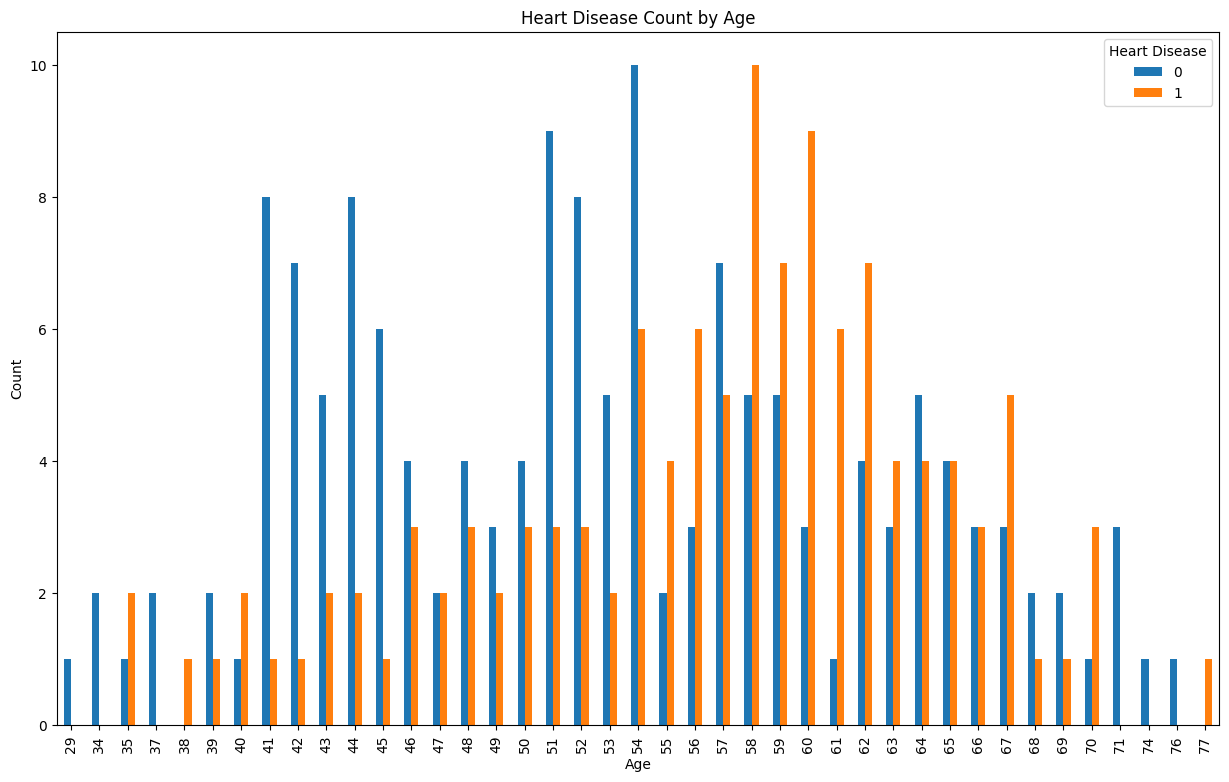

In [556]:
pd.crosstab(df['Age'], df['Heart Disease']).plot(kind="bar",figsize=(15,9))
plt.title("Heart Disease Count by Age")
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Next we'll create a heatmap to visualize correlations between factors

<Axes: >

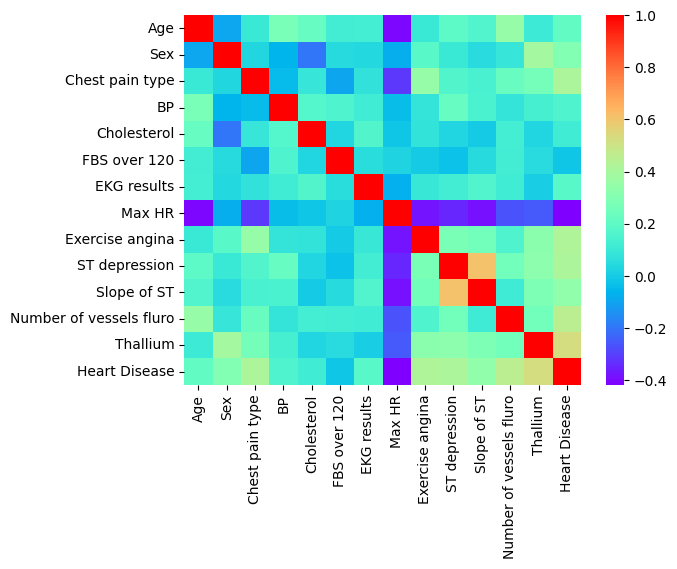

In [557]:
sn.heatmap(df.corr(),cmap="rainbow")

It appears that Max HR tends to have the highest negative degree of interaction with other variables, specifically with Age, Exercise angina (chest pain), and ST results (which have to do with ECG results).

The highest positive degree of interaction occurs between Slope of ST and ST depression, which makes sense, as they have to do with ECG graph readings.

In [558]:
# Create our X data to 'not know about heart disease outcome' and our y data to contain the heart disease results
# This will lead to us training on both heart disease positive and negative results
# Intuitively, it seems this option is better than just training on positive/negative diagnoses,
# ESPECIALLY because of our data set's small number of inputs
X=df.drop(['Heart Disease'], axis=1)
y=df['Heart Disease']
# Verify
print(X.shape)
print(y.shape)
print(y[:10])

(270, 13)
(270,)
0    1
1    0
2    1
3    0
4    0
5    0
6    1
7    1
8    1
9    1
Name: Heart Disease, dtype: int64


In [559]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42) # Using a train size of 75%
# Verify 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(202, 13)
(68, 13)
(202,)
(68,)


In [560]:
# NOTE: do not run this cell more than once without running cells above -- 
# This will create invalid dimensions + errors down the line
# Need to make y_train have definitive shape for later model compilation and encoding purposes
# To do this we'll turn it categorical
from keras.utils.np_utils import to_categorical 
y_train = to_categorical(y_train, num_classes=None)
y_test = to_categorical(y_test, num_classes=None)
print(y_train.shape)
print(y_test.shape)

(202, 2)
(68, 2)


In [566]:
# Create easy variable names so we can easily tweak parameters during training
batch_size = 8
epoch_num = 300

Kregularizer = regularizers.l2(0.001) # kernel regularizer
Aregularizer = regularizers.l2(.001) # activity regularizer
# Input layer must have 'X_train number' of factors
#input_layer = Input(shape=(X_train.shape[1],))
input_dim_num = X_train.shape[1] # = 13
print(input_dim_num)

13


In [567]:
# Declare a model, as opposed to recoding and decoding same variable(s) --
# Making changes to a single 'model object' makes more intuitive sense to me
model = Sequential()
# Add density encoding
# Note: after extensive trial/error relu--relu--relu--softmax appears to be the best order and types of activation
model.add(Dense(16, input_dim=input_dim_num, activation='relu', kernel_regularizer=Kregularizer, activity_regularizer=Aregularizer, name="layer_1"))
model.add(Dense(8, activation='relu', name="layer_2"))
model.add(Dense(4, activation='relu', name="layer_3"))
model.add(Dense(2, activation='softmax', name='layer_4'))

# Note: categorical_crossentropy has
#opt = keras.optimizers.Adam(learning_rate=.001)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
#print(model.summary())

In [ ]:
checkpointer = ModelCheckpoint(filepath='/content/model.h5', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_size, shuffle=True, 
                      validation_data=(X_test, y_test), verbose=1) # (Use verbose=0 to avoid clutter if needed)

In [564]:
model.save('/content/model.h5') # Save model

# Parameter Experimentation / Write-up
**Dense Layer Number:** 
I began with a batch size of 8 and epoch number of 50. I initially used no kernel_regularizer or activity_regularizer. I wanted to determine the number of dense layers best suited for my data. I knew 1 layer wouldn't be a good fit due to the lack of linearity in my data. To determine if I should use 2, 3, or 4 layers, I ran my model with the different number of layers. I used ReLU activation for the first x-layers, and always ended with sigmoid activation

**Activation types and ordering**
At first I was testing every possible combination of activation functions. However, I realized this was way too tedious, and decided to do some research to figure out how each function works, and what the standard approach is. 
After my research I still didn't have a *complete* understanding of what my best approach would be, but it seemed that using mostly linear (or ReLU) activation functions is best, but it's important to not use linear/relu functions for the last (few) dense layer(s). Through some trial and error, I ended up with ReLU, ReLU, ReLU, and Softmax functions in that order. My research suggested that a Sigmoid function would be best for the last layer, especially because my classification is binary (had heart disease or doesn't), but for some reason Softmax worked better so I picked it.

**Optimizer**
I started with Adam using default parameters (spoiler: ended up being the best pick). Then I tried Nadam, which converged to a similar accuracy faster (as you would expect), but had more issues with batch size later down the line, and when I increased my epoch number, Nadam's speed advantage became irrelevant. Then I tried Stochastic Gradient Descent, which got stuck at a local minima. To fix this problem, I messed around with its learning rate, but didn't get anywhere. I knew that technically if I make the learning rate small enough it will eventually get out of any local minima, but even when I used 500 epochs it was still stuck, so I moved on.
Then I tried RMSprop which worked pretty well, but not quite as well as Adam, so I went back to using Adam. I messed around with some learning rates for Adam, but default seemed to be the best.

**Batch Size**
I tried upping my batch size to 16, which resulted in me getting stuck at bad accuracies repeatedly (even when I used Nadam in combination with the higher batch size). Then I upped it to 32, which gave the same results. I then tried a batch size of 4, which seemed to just be a slower version of 8, so I went back to a batch size of 8.

**Kernel and Activity regularizers**
Up until this point, I hadn't used any kernel or activity regularizers. I did some research on them, asked ChatGPT a few questions, and added a kernel regularizer with a value of .001. It provided significant accuracy increases, so I then tried .0001, which led to a decrease in performance. .01 was then tested but also didn't give nearly as accurate results as .001, so I stuck with that. Then the literal exact same sequence occurred when determining optimal activity regularizer, so I picked .001 for its value as well.

**Epoch number** 
During the majority of my parameter testing I used 50 epochs for the sake of time. Occassionally when I had similar results (say, between Adam and Nadam), I would run a test or two with ~500 epochs as a sort of 'tie break'. Eventually, after all of my parameters were set in stone, I graphed my accuracy using 500 epochs (see below), and saw that the peaks steadied out by around 300 iterations (at around 83-90%), so I set my epoch number to 300.


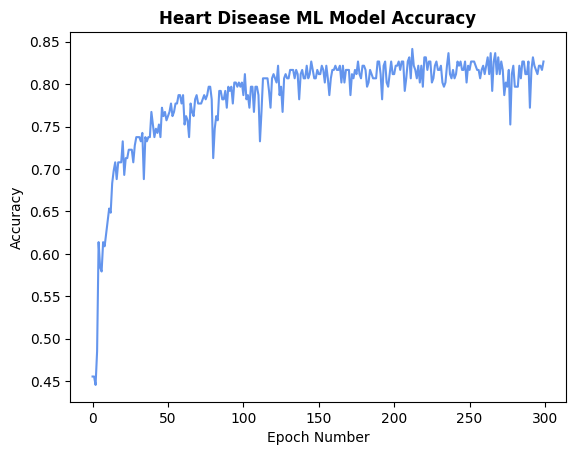

In [569]:
# Plot our accuracy
plt.plot(history.history['accuracy'], color='cornflowerblue')
plt.ylabel("Accuracy")
plt.xlabel("Epoch Number")
plt.title("Heart Disease ML Model Accuracy", fontweight='bold')
plt.show()

In [571]:
acc = max(history.history['accuracy'])
print(acc)

0.8415841460227966


**We see our accuracy to be between 83 and 89%** 🥳🥳

**Something that *didn't* go as planned**:
Towards the end, I wanted to create a visualization of my ML model's accuracy. I initially wanted a confusion matrix because it makes the most intuitive sense in my opinion, but the dimensions of my testing data and model's output didn't match. I then learned about reshaping and tried a myriad of ways to reshape, but it was futile. Now I know that there was an inherent issue. Maybe there is some workaround or I missed something, but I believe I needed to run 'decode layers' to bring the training data's dimensions back to be compatible.

References:

*   https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions/52388406#52388406
*   https://stackoverflow.com/questions/51047676/how-to-get-accuracy-of-model-using-keras
* https://stackoverflow.com/questions/38015181/accuracy-score-valueerror-cant-handle-mix-of-binary-and-continuous-target
* https://forum.freecodecamp.org/t/trouble-with-model-predict/469886